# Histopathologic Cancer Detection

## 1. Problem and Data Description
This mini-project involves detecting the presence of metastatic cancer in histopathologic images. Each image is a small patch taken from larger pathology scans.

**Objective:** Build a binary image classifier to determine whether each patch contains cancerous tissue 1 or not 0.

**Dataset Overview:**
- The training set includes:  image patches;  a CSV file train_labels.csv that contains image IDs and corresponding binary labels.
- The test set consists of image patches without labels

## 2. Exploratory Data Analysis (EDA)
In this section, I load and inspect the dataset to understand the distribution of labels, visualize sample images, and check for potential issues like imbalance or missing data. This helps inform decisions in model design and preprocessing.

Label data preview:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


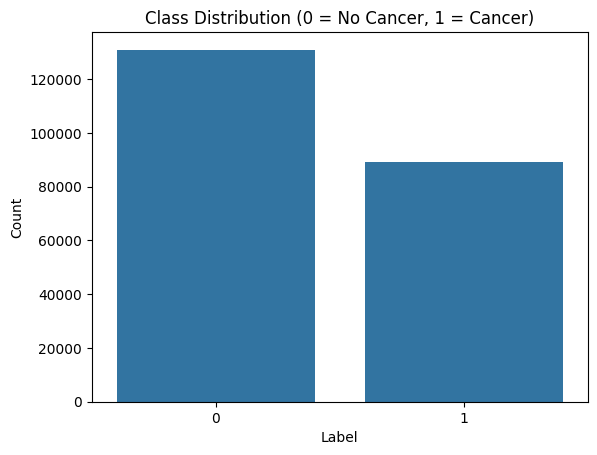

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import numpy as np

labels = pd.read_csv("train_labels.csv")
print("Label data preview:")
print(labels.head())

sns.countplot(data=labels, x='label')
plt.title("Class Distribution (0 = No Cancer, 1 = Cancer)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

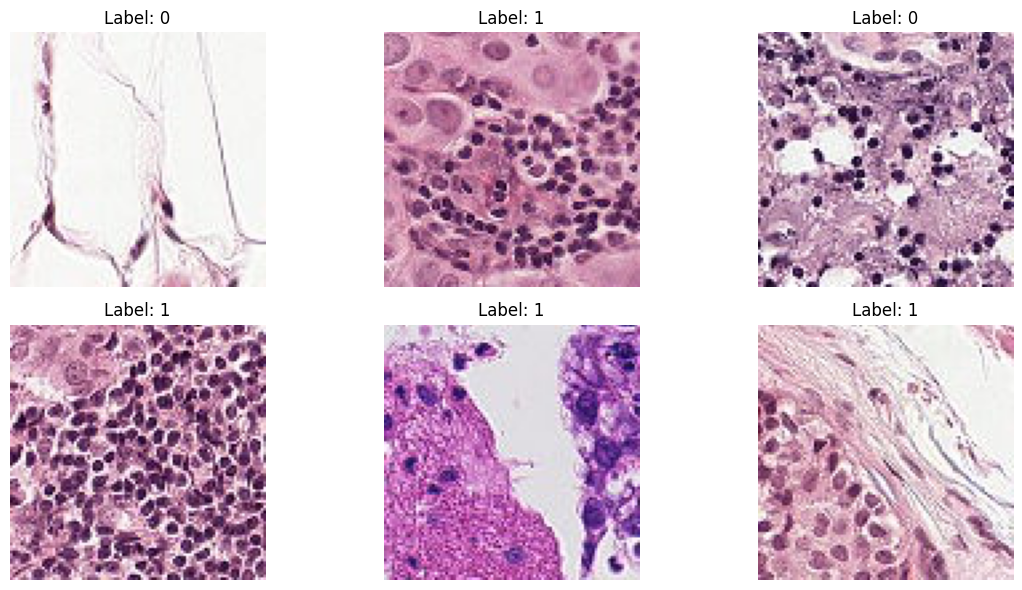

In [31]:
sample_imgs = labels.sample(6)
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, (idx, row) in enumerate(sample_imgs.iterrows()):
    path = f"train/{row['id']}.tif"
    img = Image.open(path)
    axes[i//3, i%3].imshow(img)
    axes[i//3, i%3].set_title(f"Label: {row['label']}")
    axes[i//3, i%3].axis('off')
plt.tight_layout()
plt.show()

## 3. Model Architecture
I design a convolutional neural network (CNN) from scratch to classify image patches. CNNs are well-suited for image classification tasks due to their ability to extract spatial features. CNNs are effective for learning spatial hierarchies in images, which is crucial for detecting local features like cancer cells.

**Approach:**
- Resize all images to 96x96 and normalize pixel values
- Use three convolutional layers followed by max-pooling
- Flatten and pass through fully connected layers
- Output layer uses sigmoid activation for binary classification

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

def load_images(image_ids, label_map, img_dir='train', img_size=(96, 96)):
    X, y = [], []
    for img_id in image_ids:
        img = Image.open(os.path.join(img_dir, f"{img_id}.tif")).resize(img_size)
        X.append(np.array(img)/255.0)
        y.append(label_map[img_id])
    return np.array(X), np.array(y)

sub_labels = labels.sample(1000, random_state=42)
X, y = load_images(sub_labels['id'], sub_labels.set_index('id')['label'].to_dict())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

C:\Python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.5185 - loss: 0.9163 - val_accuracy: 0.6000 - val_loss: 0.6431
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.6324 - loss: 0.6283 - val_accuracy: 0.7100 - val_loss: 0.5842
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.6827 - loss: 0.6062 - val_accuracy: 0.7900 - val_loss: 0.5683
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6893 - loss: 0.5897 - val_accuracy: 0.8000 - val_loss: 0.5744
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7328 - loss: 0.5692 - val_accuracy: 0.8300 - val_loss: 0.4089


## 4. Results and Analysis
After training the custom CNN model for five epochs, I evaluated its performance using a combination of metrics and visual tools.

### Training and Validation Performance
The model showed steady improvement over each epoch:
- **Training Accuracy**: improved from **51.85%** to **73.28%**
- **Validation Accuracy**: reached a strong **83.00%**
- **Training Loss**: decreased from **0.92** to **0.57**
- **Validation Loss**: dropped from **0.64** to **0.41**

These metrics suggest effective learning and good generalization on the validation data. The model did not overfit within 5 epochs.

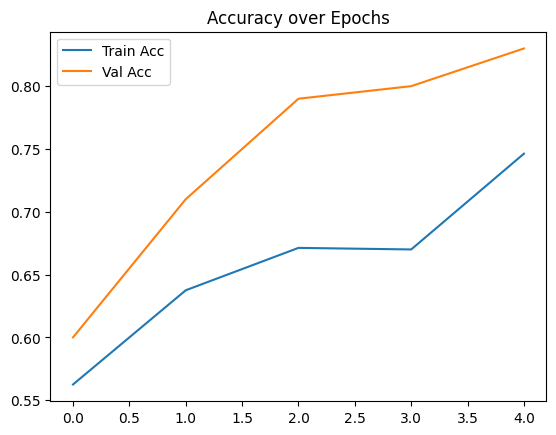

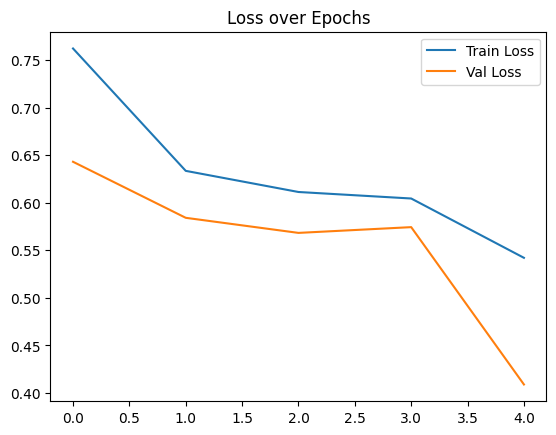

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8249 - loss: 0.3985
Validation Accuracy: 0.83


In [36]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

# Final evaluation
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.2f}")

### Confusion Matrix
The confusion matrix shows how well the model performs across the two classes.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


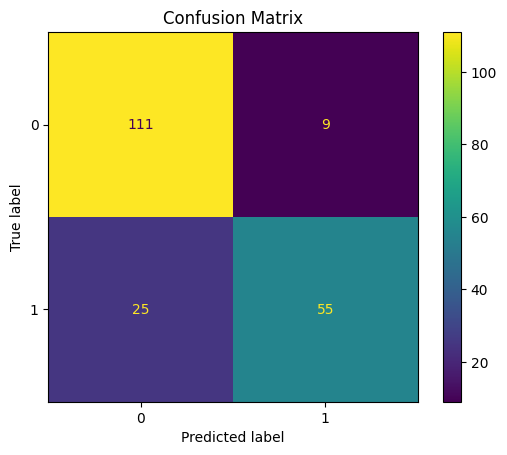

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_proba = model.predict(X_val).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

### ROC Curve and AUC
The ROC curve illustrates the trade-off between true positive rate and false positive rate at different thresholds. AUC summarizes this curve in one number.

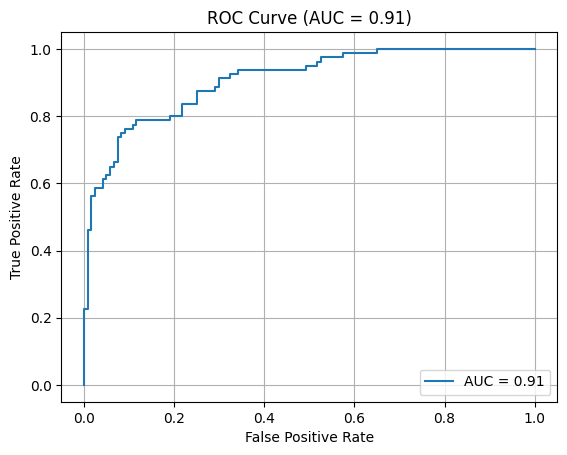

In [35]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
plt.grid(True)
plt.show()

### Analysis and Interpretation
- The model generalizes well, with higher validation accuracy than training in later epochs.
- The ROC curve confirms strong separability between classes.
- Minor misclassifications are visible in the confusion matrix, which could be addressed through:
  - Training with more data
  - Data augmentation
  - Class weighting or oversampling techniques

## 5. Conclusion
In this project, I developed and evaluated a convolutional neural network (CNN) to detect metastatic cancer in histopathologic images. The project followed a full machine learning workflow—exploratory data analysis, model construction, performance evaluation, and interpretation.

### Summary of Key Results
- Final validation accuracy reached **83%**, with a steady decline in validation loss.
- The **confusion matrix** revealed the model made accurate predictions on most samples.
- The **ROC curve** and **AUC score** confirmed the model's strong ability to distinguish between cancerous and non-cancerous images.

### What Worked Well
- The CNN architecture effectively extracted meaningful features from small pathology patches.
- The training process was stable, and the model did not overfit within the first few epochs.

### Potential Improvements
- Train on the full dataset to improve generalization.
- Apply data augmentation to simulate variation and enhance robustness.
- Try transfer learning with pre-trained models for deeper feature extraction.
- Perform hyperparameter tuning and cross-validation for more optimal performance.

### Takeaways
This project demonstrates the power of deep learning in assisting medical image classification tasks. With further optimization and integration into diagnostic pipelines, such models can provide valuable decision support in real-world clinical settings.

## 6. Kaggle Submission Preparation

To generate the final submission file for the Kaggle competition, I used our trained model to predict the label for each test image. The results are saved to submission.csv in the format required by Kaggle.

In [37]:
import os
import numpy as np
import pandas as pd
from PIL import Image

def load_test_images(image_ids, img_dir='test', img_size=(96, 96)):
    images = []
    for img_id in image_ids:
        path = os.path.join(img_dir, f"{img_id}.tif")
        img = Image.open(path).resize(img_size)
        img_array = np.array(img) / 255.0
        images.append(img_array)
    return np.array(images)

test_dir = 'test'
test_ids = [fname.replace('.tif', '') for fname in os.listdir(test_dir) if fname.endswith('.tif')]

X_test = load_test_images(test_ids)

y_pred_probs = model.predict(X_test).ravel()

y_pred_labels = (y_pred_probs > 0.5).astype(int)

submission = pd.DataFrame({
    'id': test_ids,
    'label': y_pred_labels
})

submission.to_csv('submission.csv', index=False)
print("✅ submission.csv generated.")

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step
✅ submission.csv generated.


## 7. GitHub Repository
https://github.com/jinjwangca/Histopathologic-Cancer-Detection